<h1>Image classification with KNN</h1>

In [61]:
!pip install opencv-python-headless --upgrade --quiet
!pip install numpy pandas matplotlib seaborn imutils scikit-learn

<h3>importing libraries</h3>

In [62]:
#libraries for data processing and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imutils import paths
import seaborn as sns
import random
import time
from datetime import datetime
import requests
import zipfile
import json


In [63]:
#libraries for image pre-processingand classification
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

#libraries for os
import io
import os

<h3>Downloading images and annotations</h3>

In [64]:
# URL of the ZIP file
url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/RdukW75jUsonAnS20t3n_g/training-an-image-classifier-w-2025-05-22-t-10-27-47-719-z.zip"

# Send a GET request to the URL
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Open the zip file from the downloaded content
    with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
        zip_ref.extractall("cats_dogs")  # Extract to a target folder
    print("Download and extraction complete.")
else:
    print("Failed to download file:", response.status_code)


Download and extraction complete.


In [65]:
# Define the path to the annotations JSON file
annotations_path = "cats_dogs/training-an-image-classifier-w-2025-05-22-t-10-27-47-719-z/_annotations.json"

# Load the JSON file
with open(annotations_path, "r") as f:
    annotations = json.load(f)

# Now safely access the first five entries
first_five = {k: annotations["annotations"][k] for k in list(annotations["annotations"])[:5]}
first_five


{'d3e2c989-2df0-448a-894b-73c72357d144.jpg': [{'label': 'cat',
   'id': 'ff776647-b5be-480c-87f6-84cefbdca45c'}],
 '7ffeaa61-34e6-4fa5-8539-8dac7c7be709.jpg': [{'label': 'dog',
   'id': 'befbe6b6-ea15-416a-bbf1-a17ea752faf4'}],
 'f5fd4d4f-cc77-4302-ba92-d208b76778ee.jpg': [{'label': 'dog',
   'id': '19fff04e-4a2f-4bcc-b4eb-e852098e7996'}],
 '80e7bab0-a96b-4e1d-8b9b-066333b757fa.jpg': [{'label': 'dog',
   'id': '3c342541-8e6b-46a5-9e5b-75750defc8e5'}],
 'fff311bd-531d-4d68-8298-2168480cee35.jpg': [{'label': 'cat',
   'id': '423cfab1-40d3-4458-a237-a900e5017788'}]}

In [66]:
# Define base folder path
base_folder = "cats_dogs/training-an-image-classifier-w-2025-05-22-t-10-27-47-719-z"

# Path to the annotations JSON file
annotations_path = os.path.join(base_folder, "_annotations.json")

# Load the JSON data
with open(annotations_path, "r") as f:
    annotations = json.load(f)

print("Annotations loaded successfully!")

Annotations loaded successfully!


In [67]:
# Pick a random image from the annotations
random_image_name = random.choice(list(annotations["annotations"].keys()))

# Get the label for that image
label = annotations["annotations"][random_image_name][0]["label"]

print(f"Random image selected: {random_image_name}")
print(f"Label: {label}")

Random image selected: e58b4183-e723-40a5-acce-12c36f8f4fb4.jpg
Label: dog


In [68]:
# Construct full path to image
image_path = os.path.join(base_folder, random_image_name)

# Read image using OpenCV
img = cv2.imread(image_path)
if img is None:
    raise FileNotFoundError(f"Image not found at {image_path}")
print("Full image path:", image_path)


Full image path: cats_dogs/training-an-image-classifier-w-2025-05-22-t-10-27-47-719-z/e58b4183-e723-40a5-acce-12c36f8f4fb4.jpg


<h3>Convert BGR to RGB and display</h3>
<p>We converted the image from BGR to RGB color space so it can be displayed correctly using matplotlib. This is necessary because OpenCV reads images in BGR format by default, a convention originally adopted due to its popularity among early camera manufacturers and software providers.</p>

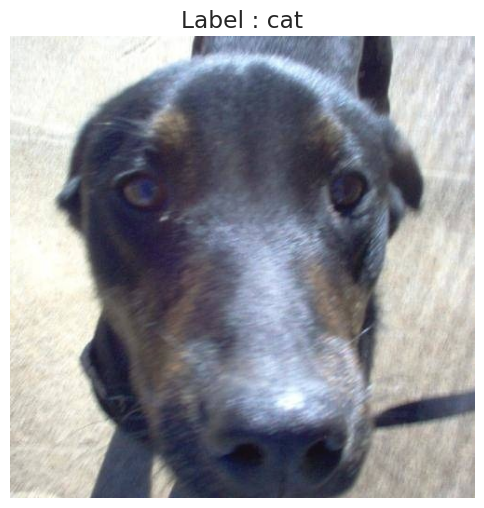

In [69]:
#converting image from BGR to RGB
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
tmp_label = annotations["annotations"][filename][0]['label']
label = class_object.index(tmp_label)
#plotting the image by using matplotlib
plt.figure(figsize=(6, 6))
plt.imshow(img_rgb)
plt.title(f"Label : {tmp_label}")
plt.axis("off")
plt.show()

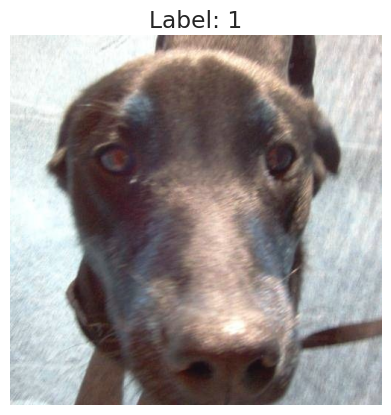

In [70]:
# if you plot img(BGR image), you will observe a difference in the color space
plt.imshow(img)
plt.axis('off')
plt.title(f"Label: {label}")
plt.show()

<h3>Image Processing</h3>
<ul type="circle">
<li>Convert Image to Grayscale </li>
<li>Resize the image</li>
<li>Flatten image</li>
</ul>

<ul type="circle"><li>Convert image into grayscale</li></ul>

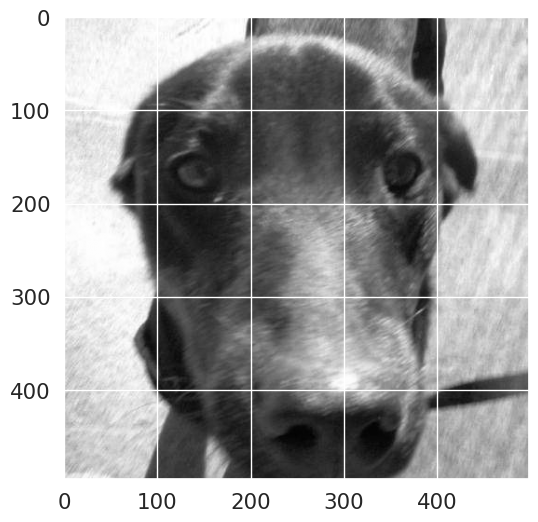

In [71]:
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(6, 6))
plt.imshow(gray_img, cmap='gray')
# plt.axis("off")
plt.show()

<ul type="circle"><li>Resize the image</li></ul>

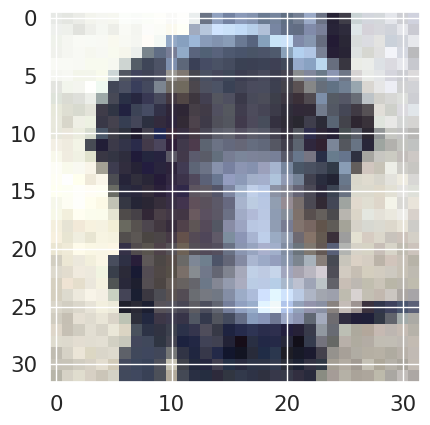

In [72]:
sample_image = cv2.resize(img_rgb, (32, 32))
plt.imshow(sample_image, cmap = "gray")
plt.show()

<ul type="circle"><li>Flatten image
</li></ul>

In [73]:
#makes image as a numpy array for the algorithm to handle and recognize
pixels = gray_img.flatten()
pixels

array([236, 243, 243, ..., 161, 169, 175], dtype=uint8)

<h3>Repeat the process for all the images in dataset</h3>
<p>We will now repeat the same process above to load and process all the images you’ve annotated and label each picture. KNN is supervised machine learning algorithm, therefore we have to explicitly create labels for the machine.</p>

In [74]:
#Prepare all image file paths from the dataset folder
# Get all image file paths from the dataset folder
image_paths = list(paths.list_images(base_folder))

# Create empty lists to store image data and corresponding labels
train_images = []
train_labels = []

# Extract the list of class labels (e.g., ['dog', 'cat']) from the annotations
class_object = annotations['labels']

In [75]:
#Process and label each image
from tqdm import tqdm
# Process each image with a progress bar
for image_path in tqdm(image_paths, desc="Loading images"):
    filename = os.path.basename(image_path)

    # Skip if not in annotation
    if filename not in annotations["annotations"]:
        continue  # silently skip

    # Load image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, (32, 32))
    pixels = image.flatten()

    # Get label
    tmp_label = annotations["annotations"][filename][0]['label']
    label = class_object.index(tmp_label)

    # Append
    train_images.append(pixels)
    train_labels.append(label)




Loading images: 100%|██████████| 800/800 [00:01<00:00, 577.81it/s]


In [76]:
train_images = np.array(train_images).astype('float32')
train_labels = np.array(train_labels)
print(train_images[:2])
print(train_labels[:10])

[[ 94.  98.  92. ... 152. 157. 154.]
 [248. 243. 254. ... 102. 115.  89.]]
[0 1 0 1 1 1 0 1 0 0]


In [77]:
train_labels = train_labels.astype(int)
train_labels = train_labels.reshape((train_labels.size,1))
print("First 5 labels:\n", train_labels[:5])

First 5 labels:
 [[0]
 [1]
 [0]
 [1]
 [1]]


<h3>Train a K-NN cllasifier for image classification</h3>

In [78]:
print(f"Number of images: {len(train_images)}")
print(f"Number of labels: {len(train_labels)}")

Number of images: 800
Number of labels: 800


In [79]:
test_size = 0.2
train_samples, test_samples, train_labels, test_labels = train_test_split(
    train_images, train_labels, test_size=test_size, stratify=train_labels,random_state=0)


In [80]:
# Record the start time to measure training duration
start_datetime = datetime.now()

# Create a KNN model using OpenCV's machine learning module
knn = cv2.ml.KNearest_create()

# Train the model using training samples and corresponding labels
# cv2.ml.ROW_SAMPLE specifies that each row in train_samples is a separate sample
knn.train(train_samples, cv2.ml.ROW_SAMPLE, train_labels)

# Define different values of K to evaluate
k_values = [1, 2, 3, 4, 5]
k_result = []  # To store the prediction results for each value of K

# Loop through each K value and test the model on test samples
for k in k_values:
    ret, result, neighbours, dist = knn.findNearest(test_samples, k=k)
    k_result.append(result)  # Save the result for this value of K

# Flatten the result arrays for easier comparison later
flattened = []
for res in k_result:
    # Each `res` is a 2D array; flatten it into a 1D list
    flat_result = [item for sublist in res for item in sublist]
    flattened.append(flat_result)

# Record end time and print how long training + prediction took
end_datetime = datetime.now()
print('Training Duration: ' + str(end_datetime - start_datetime))


Training Duration: 0:00:00.263207


In [81]:
# Create empty lists to store accuracy results and confusion matrices for each K
accuracy_res = []
con_matrix = []

# Loop over the results for each value of K
for k_res in k_result:
    # Define the class labels (e.g., 0 = Cat, 1 = Dog)
    label_names = [0, 1]

    # Compute the confusion matrix for predictions vs. true labels
    cmx = confusion_matrix(test_labels, k_res, labels=label_names)
    con_matrix.append(cmx)

    # Check which predictions match the true labels
    matches = k_res == test_labels

    # Count how many predictions were correct
    correct = np.count_nonzero(matches)

    # Calculate accuracy as a percentage
    accuracy = correct * 100.0 / result.size
    accuracy_res.append(accuracy)

# Store the accuracy for each value of K in a dictionary (key = K, value = accuracy)
res_accuracy = {k_values[i]: accuracy_res[i] for i in range(len(k_values))}

# Sort the results by K value to make them easier to read or plot
list_res = sorted(res_accuracy.items())


In [82]:
print("\nAccuracy per k:")
for k, acc in list_res:
    print(f"k = {k}: {acc:.2f}%")


Accuracy per k:
k = 1: 100.00%
k = 2: 100.00%
k = 3: 100.00%
k = 4: 90.00%
k = 5: 81.25%


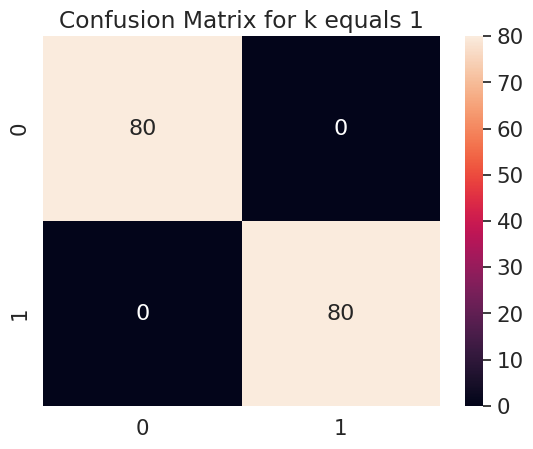

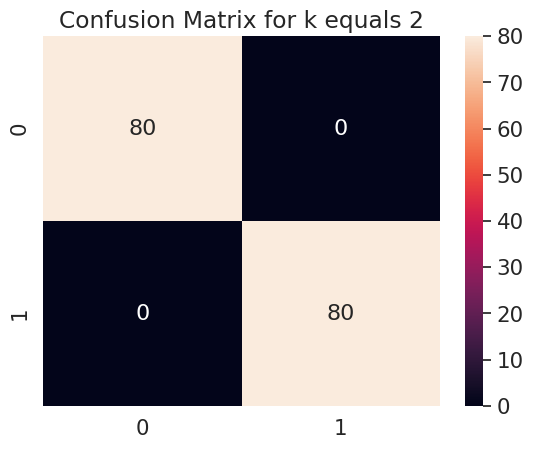

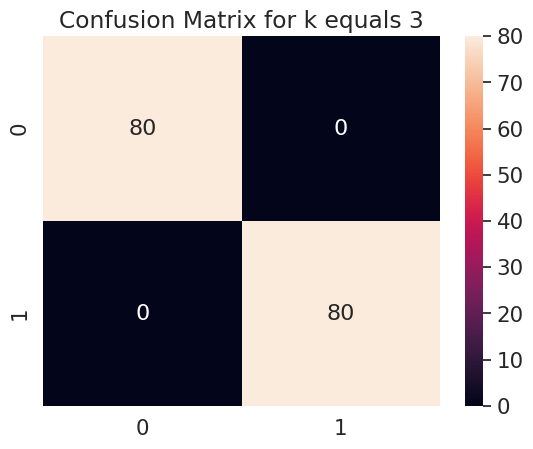

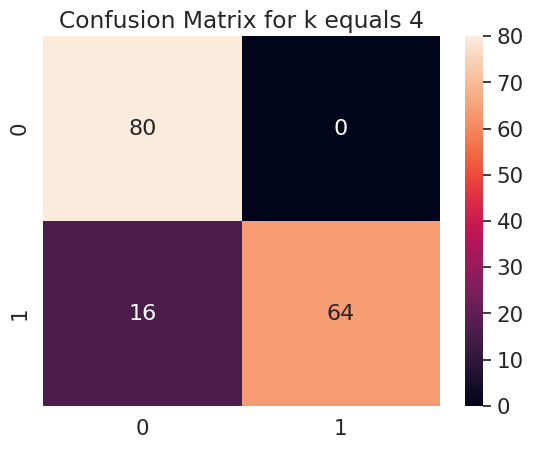

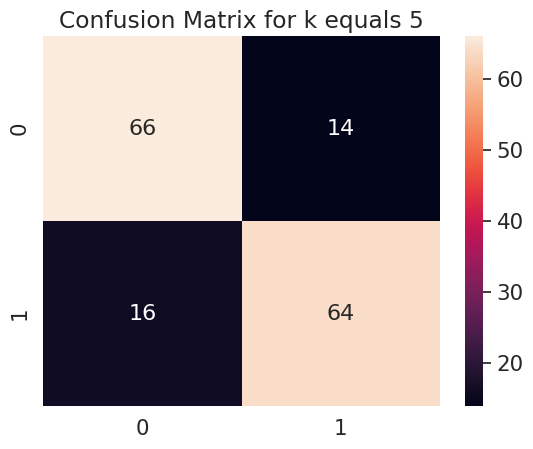

In [83]:
t = 0  # Initialize counter for k values

# Loop through each confusion matrix corresponding to different k values
for array in con_matrix:
    # Convert the confusion matrix array into a pandas DataFrame for better visualization
    df_cm = pd.DataFrame(array)

    # Set the font scale for better readability
    sns.set(font_scale=1.4)

    # Create the heatmap from the DataFrame
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt=".0f")  # fmt=".0f" ensures whole numbers are shown

    # Update k counter
    t += 1

    # Set the title for each confusion matrix plot
    title = "Confusion Matrix for k equals " + str(t)
    plt.title(title)

    # Show the plot
    plt.show()


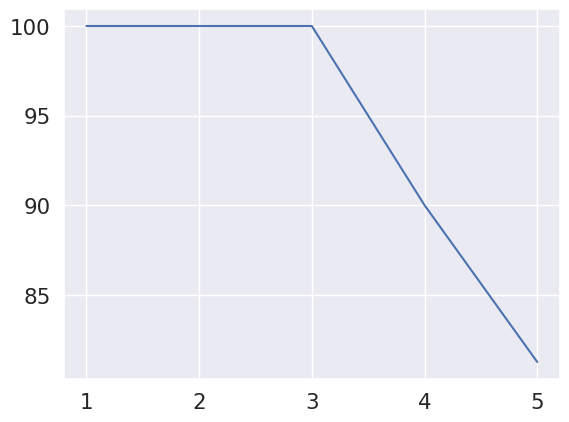

In [84]:
## plot accuracy against
x, y = zip(*list_res)
plt.plot(x, y)
plt.show()

In [85]:
k_best = max(list_res,key=lambda item:item[1])[0]
k_best

1

In [86]:
knn.save('knn_samples.yml')

In [87]:
knn = cv2.ml.KNearest_create()
knn = knn.load('knn_samples.yml')


In [88]:
!wget "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/A3xVgxTJVdrZTtBwGVbEIw/Cat.jpg"
!wget "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/KZnFQiZj3e_sQKIyfvHvTA/dog.jpg"


--2025-12-04 19:43:41--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/A3xVgxTJVdrZTtBwGVbEIw/Cat.jpg
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.63.118.104
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.63.118.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 188980 (185K) [image/jpeg]
Saving to: ‘Cat.jpg.1’

Cat.jpg.1           100%[===================>] 184.55K  --.-KB/s    in 0.05s   

2025-12-04 19:43:41 (3.97 MB/s) - ‘Cat.jpg.1’ saved [188980/188980]

--2025-12-04 19:43:41--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/KZnFQiZj3e_sQKIyfvHvTA/dog.jpg
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.63.118.104
Connecting to cf-courses-data.s3.u

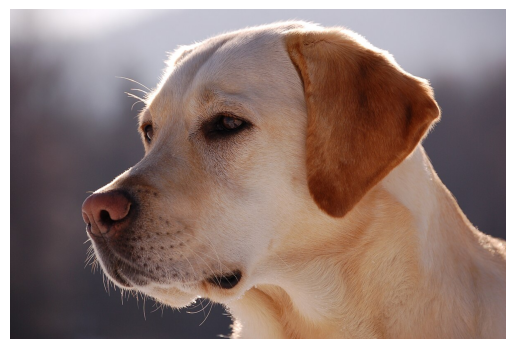

In [89]:
my_image = cv2.imread("dog.jpg")
## let's see what the image looks like
image = cv2.cvtColor(my_image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.axis('off')
plt.show()

In [90]:
my_image = cv2.cvtColor(my_image,cv2.COLOR_BGR2GRAY)
my_image = cv2.resize(my_image, (32, 32))
pixel_image = my_image.flatten()
pixel_image = np.array([pixel_image]).astype('float32')

In [91]:
ret,result,neighbours,dist = knn.findNearest(pixel_image,k=k_best)
print("Nearest Neighbours' Labels:\n", neighbours)
predicted_index = int(ret)
predicted_label = annotations['labels'][predicted_index]
print(f"Your image was classified as a **{predicted_label}**")


Nearest Neighbours' Labels:
 [[0.]]
Your image was classified as a **dog**
